<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic13/Chollet_HFST13_keras_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

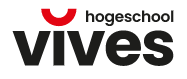<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# Hyperparameter optimization using KerasTuner

Deze notebook bevat de codevoorbeelden over KerasTuner uit hoofdstuk 13.1.1 van het boek "Deep Learning with Python" (2e editie) van François Chollet.

In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 135 kB 30.8 MB/s 
     |████████████████████████████████| 1.6 MB 45.3 MB/s 


**A KerasTuner model-building function**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    units = hp.Int(name="units", min_value=16, max_value=64, step=16)
    model = keras.Sequential([
        layers.Dense(units, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])
    optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"])
    return model

**A KerasTuner `HyperModel`**

In [ ]:
import kerastuner as kt

class SimpleMLP(kt.HyperModel):
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        units = hp.Int(name="units", min_value=16, max_value=64, step=16)
        model = keras.Sequential([
            layers.Dense(units, activation="relu"),
            layers.Dense(self.num_classes, activation="softmax")
        ])
        optimizer = hp.Choice(name="optimizer", values=["rmsprop", "adam"])
        model.compile(
            optimizer=optimizer,
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        return model

hypermodel = SimpleMLP(num_classes=10)

<ipython-input-4-643dcc05e516>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=100,
    executions_per_trial=2,
    directory="mnist_kt_test",
    overwrite=True,
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': None}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((-1, 28 * 28)).astype("float32") / 255
x_test = x_test.reshape((-1, 28 * 28)).astype("float32") / 255
x_train_full = x_train[:]
y_train_full = y_train[:]
num_val_samples = 10000
x_train, x_val = x_train[:-num_val_samples], x_train[-num_val_samples:]
y_train, y_val = y_train[:-num_val_samples], y_train[-num_val_samples:]

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
]
tuner.search(
    x_train, y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=2,
)

Trial 100 Complete [00h 01m 08s]
val_accuracy: 0.9736999869346619

Best val_accuracy So Far: 0.9764000177383423
Total elapsed time: 01h 43m 45s


**Querying the best hyperparameter configurations**

In [ ]:
top_n = 4
best_hps = tuner.get_best_hyperparameters(top_n)

In [ ]:
def get_best_epoch(hp):
    model = build_model(hp)
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=10)
    ]
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=callbacks)
    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch

In [ ]:
def get_best_trained_model(hp):
    best_epoch = get_best_epoch(hp)
    model = build_model(hp)
    model.fit(
        x_train_full, y_train_full,
        batch_size=128, epochs=int(best_epoch * 1.2))
    return model

best_models = []
for hp in best_hps:
    model = get_best_trained_model(hp)
    model.evaluate(x_test, y_test)
    best_models.append(model)

Epoch 1/100
391/391 [==============================] - 2s 4ms/step - loss: 0.4479 - accuracy: 0.8792 - val_loss: 0.2382 - val_accuracy: 0.9355
Epoch 2/100
391/391 [==============================] - 1s 3ms/step - loss: 0.2204 - accuracy: 0.9373 - val_loss: 0.1837 - val_accuracy: 0.9504
Epoch 3/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1694 - accuracy: 0.9518 - val_loss: 0.1554 - val_accuracy: 0.9563
Epoch 4/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1377 - accuracy: 0.9606 - val_loss: 0.1375 - val_accuracy: 0.9611
Epoch 5/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1169 - accuracy: 0.9666 - val_loss: 0.1219 - val_accuracy: 0.9667
Epoch 6/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1019 - accuracy: 0.9708 - val_loss: 0.1173 - val_accuracy: 0.9662
Epoch 7/100
391/391 [==============================] - 1s 3ms/step - loss: 0.0893 - accuracy: 0.9739 - val_loss: 0.1083 - val_accuracy: 0.9699

In [ ]:
best_models

In [ ]:
best_models = tuner.get_best_models(top_n)
best_models

---